###### by Ahmet Hamza Emra

## Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project I will build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. I use email and financial data for 146 executives at Enron to identify persons of interest in the fraud case.  A person of interest (POI) is someone who was indicted for fraud, settled with the government, or testified in exchange for immunity.  This report documents the machine learning techniques used in building a POI identifier.

There are four major steps in my project:  
1. Enron dataset
2. Feature processing
3. Algorithm
4. Validation


In [1]:
import os
os.chdir('../final_project/')

In [14]:
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit

### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi"]

### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

Firstly let's look how data is structured.

In [3]:
print "There are ", len(data_dict.keys()), " executives in Enron Dataset."

There are  146  executives in Enron Dataset.


In [4]:
print data_dict.keys()


['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [5]:
print data_dict['BUY RICHARD B']


{'salary': 330546, 'to_messages': 3523, 'deferral_payments': 649584, 'total_payments': 2355702, 'exercised_stock_options': 2542813, 'bonus': 900000, 'restricted_stock': 901657, 'shared_receipt_with_poi': 2333, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 3444470, 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 1053, 'other': 400572, 'from_this_person_to_poi': 71, 'poi': False, 'director_fees': 'NaN', 'deferred_income': -694862, 'long_term_incentive': 769862, 'email_address': 'rick.buy@enron.com', 'from_poi_to_this_person': 156}


## The Enron Data

First of all I’d like to have a look at my data and check it for outliers. I plot salaries and bonuses on Enron employees and see an outlier in the data.

In [6]:
features = ["salary", "bonus"]
#data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)
### plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
#plt.show()

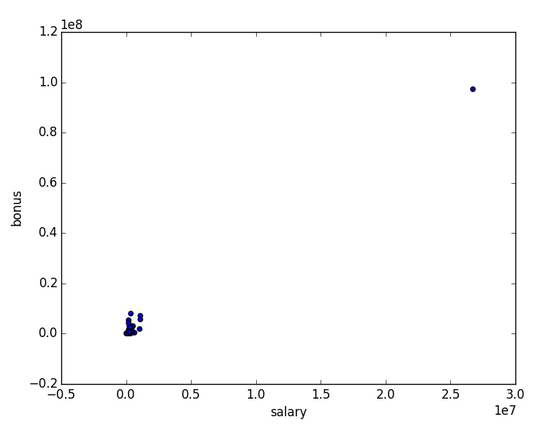

In [7]:
Image(filename='data.png')

When I check it I see this is a number for total salary and bonus. As this is not sensible information for our analysis I remove it manually. Two more outliers (SKILLING JEFFREY and LAY KENNETH) I keep in dataset as these values real and actually they are already a sign of these two managers being involved in the fraud. Now dataset look like this:


In [8]:
### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### print top 4 salaries
print outliers_final

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


In [9]:
Image(filename='data_no_outliers.png')

## Feature processing

After cleaning the data from outliers I had to pick the most sensible features to use. First I picked 'from_poi_to_this_person' and  'from_this_person_to_poi' but there is was no strong pattern when I plotted the data so I used fractions for both features of “from/to poi messages” and “total from/to messages”. 


In [24]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

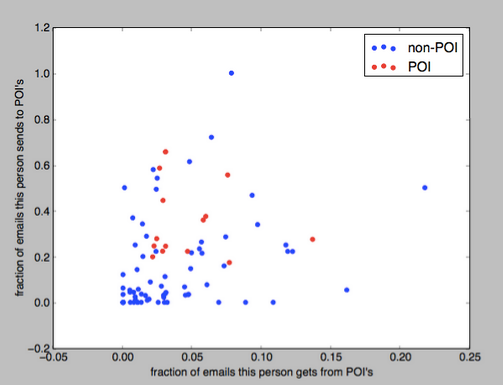

In [47]:
Image(filename='data_poi_nonpoi.png')

In order to find the most effective features for classification, feature selection using “Decision Tree”  was deployed to rank the features. Selection features was half manual iterative process. First I put all the possible features into features_list and then started deleting them one by one using score value and human intuition. I rank them with feature importance from sklearn. then I used them.

In [20]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(my_dataset, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)




from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])


accuracy 0.8
Decision tree algorithm time: 0.003 s
Feature Ranking: 
1 feature salary (0.211707133446)
2 feature bonus (0.181365499334)
3 feature fraction_from_poi_email (0.14622972935)
4 feature fraction_to_poi_email (0.120901730257)
5 feature deferral_payments (0.118337314859)
6 feature total_payments (0.0879795396419)
7 feature loan_advances (0.0747826086957)
8 feature restricted_stock_deferred (0.0377115287109)
9 feature deferred_income (0.0209849157054)
10 feature total_stock_value (0.0)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


I removed each feature one by one to determine its impact on precision and recall

1. Remove each feature one by one
2. Test precision and recall with each feature removed
3. Keep features with impact on precision and recall that exceed a difference 0.1

Finally I picked 10 features which are:
```
["salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']
```

Accuracy for this feature set is around **0.8**. 


But with these features my precision and recall were too low (less than 0.3) so I had to change my strategy and manually pick features which gave me precision and recall values over 0.3. In this dataset I cannot use accuracy for evaluating my algorithm because there a few POI’s in dataset and the best evaluator are precision and recall. There were only 18 examples of POIs in the dataset.  There were 35 people who were POIs in “real life”, but for various reasons, half of those are not present in this dataset.  


Finally I picked the following features:
**["fraction_from_poi_email", "fraction_to_poi_email", “shared_receipt_with_poi”]**


## Algorithm Selection and Tuning

In [18]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "shared_receipt_with_poi"]

### try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print accuracy

print "NB algorithm time:", round(time()-t0, 3), "s"

0.2
NB algorithm time: 0.053 s


Firstly I tried Naive Bayes accuracy was lower than with Decision Tree Algorithm (0.83 and 0.9 respectively). I made a conclusion that that the feature set I used does not suit the distributional and interactive assumptions of Naive Bayes well enough. 
I selected Decision Tree Algorithm for the POI identifier. It gave me accuracy before tuning parameters = 0.9. No feature scaling was deployed, as it’s not necessary when using a decision tree.
After selecting features and algorithm I manually tuned parameter min_samples_split. 

```
min_samples_split    precision    recall
      2                0.67        0.8
      3                0.57        0.8
      4                0.57        0.8
      5                0.8         0.8
      6                0.8         0.8
      7                0.67        0.8
   average             0.68        0.8
```   

It turned out that the best values for min_samples_split are 5 and 6.


### What validation is and why it is important
We look at our different models, and using the validation set choose the best performing one. different allgorithms has different accuracy, precision and recall scores. they works best on different datasets. So finding best one with our data is important. when we validate we use a validation set, usually a split from the training set prior to any training. We train our model and then test it against unseen data which we split off. The reason for doing this is to gauge how well our model is generalizing. We want to avoid high variance, also known as overfitting. A major mistake we can make is to use the actual data we trained on to validate, since this is no longer unseen data.
### Tuning
Tuning an algorithm or machine learning technique, can be simply thought of as process which one goes through in which they optimize the parameters that impact the model in order to enable the algorithm to perform the best


In [22]:
### use manual tuning parameter min_samples_split
clf = DecisionTreeClassifier(min_samples_split=5)

## Analysis Validation and Performance


This process was validated using 3-fold cross-validation, precision and recall scores.
First I used accuracy to evaluate my algorithm. It was a mistake because in this case we have a class imbalance problem - the number of POIs is small compared to the total number of examples in the dataset. So I had to use precision and recall for these activities instead. 
I was able to reach average value of precision = 0.68, recall =  0.8.

In [26]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']


### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print 'accuracy before tuning ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"


### use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)
print 'precision = ', precision_score(labels_test,pred)

# function for calculation ratio of true positives
# out of true positives and false negatives
print 'recall = ', recall_score(labels_test,pred)


### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

accuracy before tuning  0.866666666667
Decision tree algorithm time: 0.001 s
done in 0.001s
Validating algorithm:
accuracy after tuning =  0.933333333333
precision =  0.8
recall =  0.8


## Discussion and Conclusions

The precision can be interpreted as the likelihood that a person who is identified as a POI is actually a true POI; the fact that this is 0.68 means that using this identifier to flag POI’s would result in 32% of the positive flags being false alarms. Recall measures how likely it is that identifier will flag a POI in the test set. 80% of the time it would catch that person, and 20% of the time it wouldn’t.  
These numbers are quite good but we still can improve the strategy. One of the possible paths to improvement is digging in to the emails data more. The email features in the starter dataset were aggregated over all the messages for a given person. By digging into the text of each individual’s messages, it’s possible that more detailed patterns (say, messages to/from a specific address, rather than just messages to/from any POI address, or the usage of specific vocabulary terms) might emerge.  Since we live in a world in which more POI finance data might not be easy to find, the next realistic thing to try might be to extract more data from the emails. 
